In [1]:
## This notebook will contain linear & quantile linear regression for
    # 1. Sunspot
    # 2. Mackey-Glass
    # 3. Lorenz

In [2]:
# import libraries 
import pandas as pd                                          # for reading dataset
import numpy as np
from reservoirpy.datasets import mackey_glass 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split         # for shuffling & splitting data

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression            # for model fitting
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # for model evaluation: https://scales.arabpsychology.com/stats/interpret-mape-values/ 

import matplotlib.pyplot as plt                              # for results visualisation
import matplotlib.ticker as ticker

In [3]:
## Define function
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

# tilted loss function - crux of quantile regression
def tilted_loss(beta, X, y, tau):
    y_pred = np.dot(X, beta.reshape(X.shape[1], -1)) # multi step ahead version
    u = y - y_pred
    loss = np.where(u >= 0, tau * u, (tau - 1) * u)
    return np.sum(loss)

pm = "\u00B1"

In [4]:
## Usage: define our parameters
input_size = 8         # 8 steps input (showcase our model can handle different input/output sizes)
output_size = 4        # 4 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [5]:
# 1. Sunspot (Classic Linear regression)
Sunspot = pd.read_csv('data/Sunspots.csv')
response = Sunspot['Monthly Mean Total Sunspot Number']
scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(response).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [6]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print(f"Sunspots Data Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Sunspots Data Linear Regression: After 30 experimental runs, here are the results:
Across 4 predictive time steps, Avg RMSE: 0.0742 ± 0.0021, Avg MAE: 21.25 ± 0.47, Avg MAPE: 102053546533378672.000% ± 20988991029943532.000%
At time step 1, Avg RMSE: 0.0542 ± 0.0330, Avg MAE: 18.01 ± 0.64, Avg MAPE: 69249276128145624.000% ± 20870649197250728.000%
At time step 2, Avg RMSE: 0.0661 ± 0.0514, Avg MAE: 20.77 ± 0.71, Avg MAPE: 103478619212961728.000% ± 29584652165671136.000%
At time step 3, Avg RMSE: 0.0662 ± 0.0435, Avg MAE: 22.49 ± 0.74, Avg MAPE: 114357100117838624.000% ± 35897918251505176.000%
At time step 4, Avg RMSE: 0.0576 ± 0.0419, Avg MAE: 23.71 ± 0.62, Avg MAPE: 121129190674568976.000% ± 32743794602757744.000%


In [7]:
# MAPE not very suitable here: no need to report MAPE (not a useful model eval metric for this scenario)
# percentage difference across 6 steps stacks up quickly and the nature of the sunspots data are not suitable
    # e.g. actual = 0.01, pred = 10

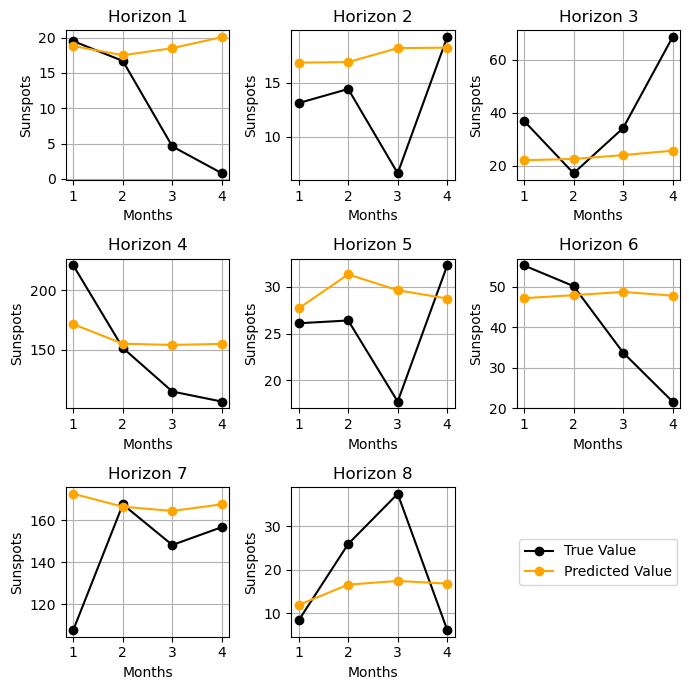

In [8]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='orange', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspots')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
# Linear Regression Quantile ver

# Usage
input_size = 8         # 8 steps input
output_size = 4        # 4 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)

# Initialize lists for metrics
rmse, mae, mape = [], [], []
quantile_rmse = {q: [] for q in quantiles}
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [10]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    print(f"Experiment {i+1}/{num_experiments} done")
    seed += 1

print(f"Sunspots Data Quantile Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f} {pm} {np.std(quantile_rmse[q]):.4f}")

Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done
Experiment 23/30 done
Experiment 24/30 done
Experiment 25/30 done
Experiment 26/30 done
Experiment 27/30 done
Experiment 28/30 done
Experiment 29/30 done
Experiment 30/30 done
Sunspots Data Quantile Linear Regression: After 30 experimental runs, here are the results:
Across 4 predictive time steps, Avg RMSE: 0.0748 ± 0.0021, Avg MAE: 21.00 ± 0.50, Avg MAPE: 53094868092318592.000% ± 13527147543386678.000%
At time step 1, Avg RMSE: 0.0548 ± 0.0350, Avg MAE: 17.85 ± 0.66, Avg MAPE: 41638357690623568.000% ± 1563383906076214

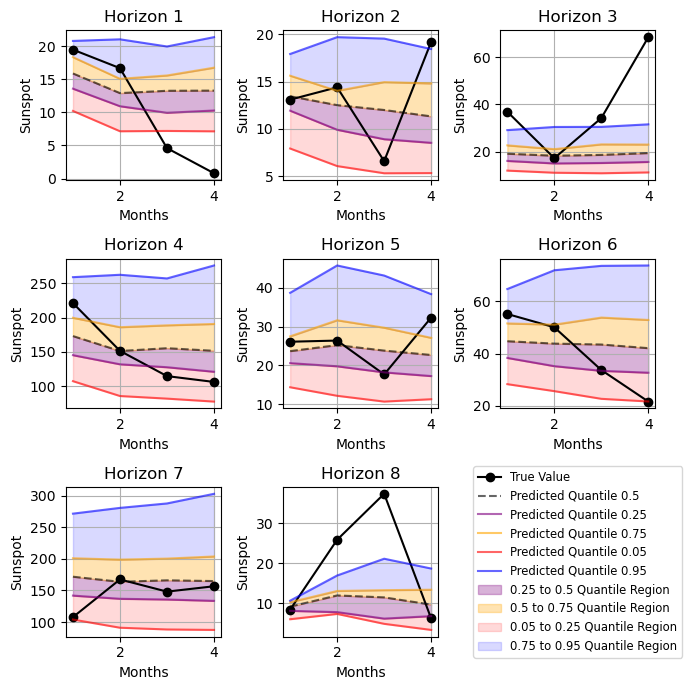

In [11]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspot')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [12]:
# 2. Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data))

scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [13]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print(f"Mackey-Glass Data Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Mackey-Glass Data Linear Regression: After 30 experimental runs, here are the results:
Across 6 predictive time steps, Avg RMSE: 0.0352 ± 0.0070, Avg MAE: 0.02 ± 0.00, Avg MAPE: 2.096% ± 0.080%
At time step 1, Avg RMSE: 0.0213 ± 0.0146, Avg MAE: 0.00 ± 0.00, Avg MAPE: 0.155% ± 0.012%
At time step 2, Avg RMSE: 0.0448 ± 0.1118, Avg MAE: 0.00 ± 0.00, Avg MAPE: 0.538% ± 0.029%
At time step 3, Avg RMSE: 0.0283 ± 0.0147, Avg MAE: 0.01 ± 0.00, Avg MAPE: 1.232% ± 0.058%
At time step 4, Avg RMSE: 0.0235 ± 0.0128, Avg MAE: 0.02 ± 0.00, Avg MAPE: 2.227% ± 0.093%
At time step 5, Avg RMSE: 0.0190 ± 0.0132, Avg MAE: 0.03 ± 0.00, Avg MAPE: 3.496% ± 0.135%
At time step 6, Avg RMSE: 0.0388 ± 0.0654, Avg MAE: 0.04 ± 0.00, Avg MAPE: 4.928% ± 0.178%


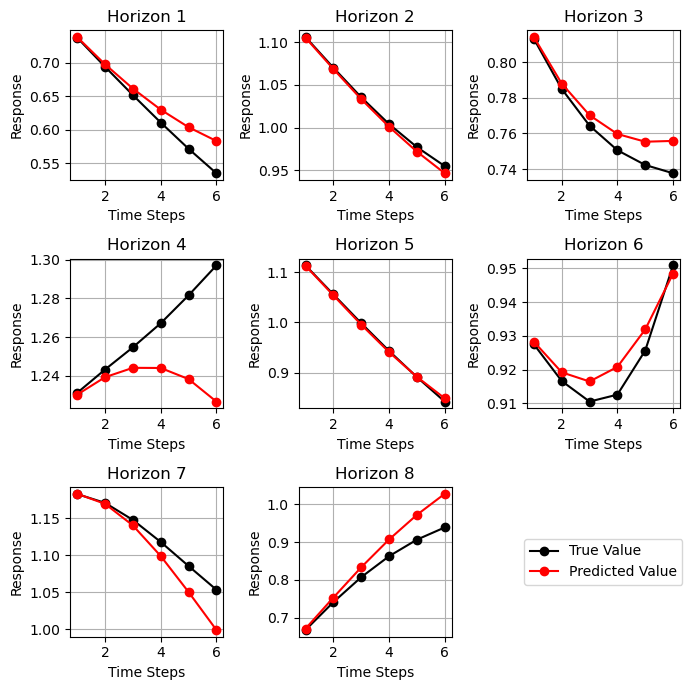

In [14]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

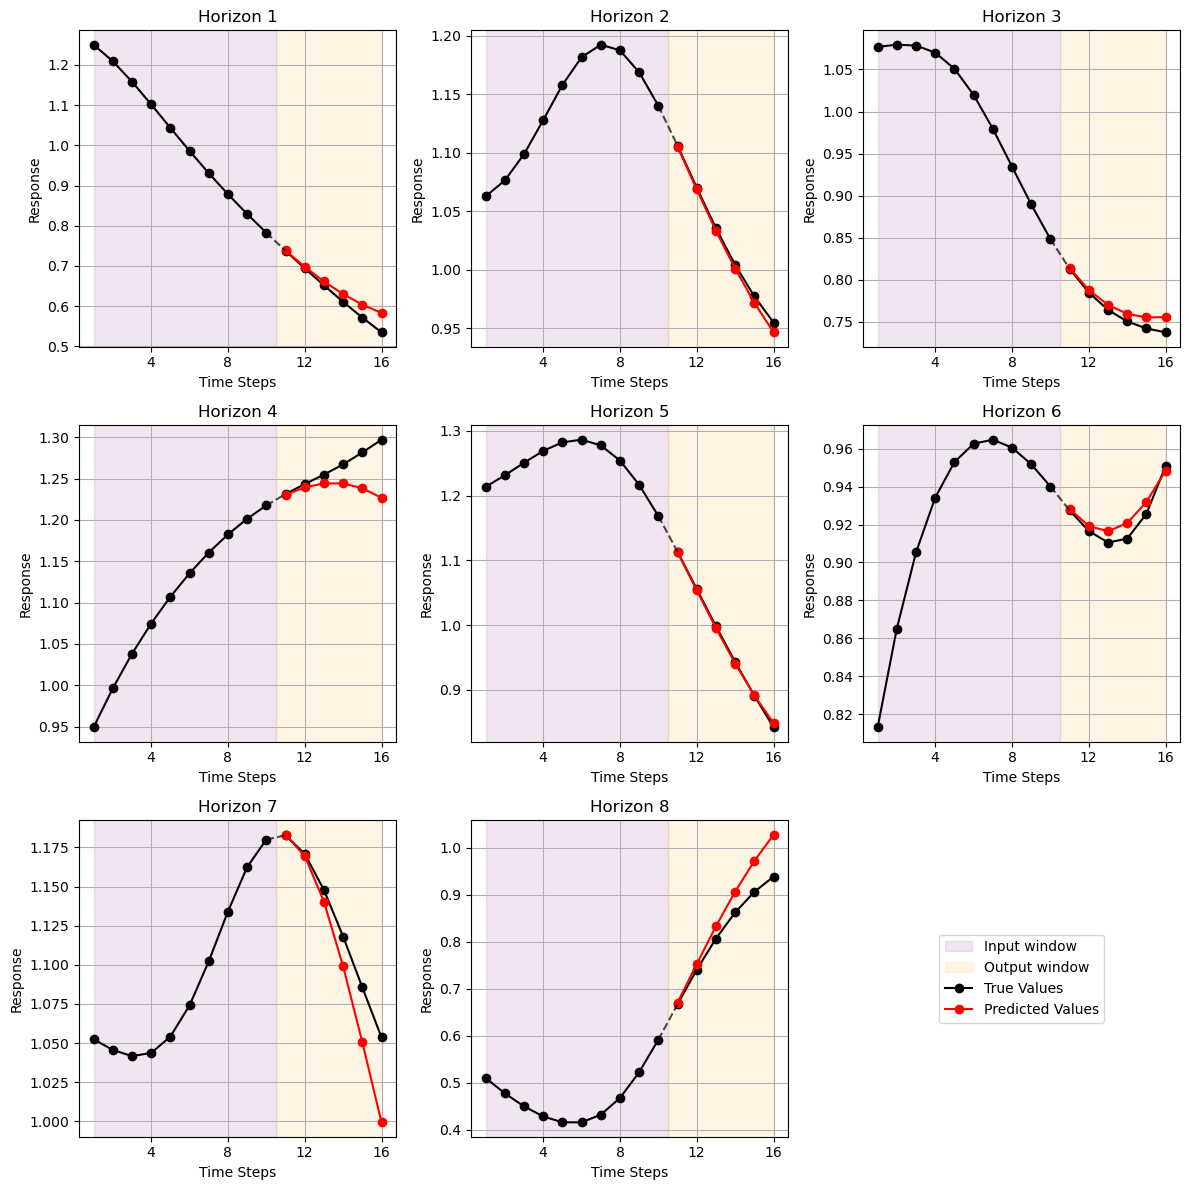

In [15]:
X_test_inv = scaler.inverse_transform(X_test)
y_test_inv = scaler.inverse_transform(y_test)

# Time steps for the entire sequence (input + output)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for i in range(8):    
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='purple', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='orange', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], y_test_inv[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Values')
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], y_test_inv[i][0]],
            linestyle='--', color='black', alpha=0.7)
    
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center') 


plt.tight_layout()
plt.show()

In [16]:
## Quantile Ver: Linear Regression Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data))

scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [17]:
# Usage
input_size = 10        # 10 steps input
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # change to lower value for less intensive runs

# Initialize lists for metrics
rmse, mae, mape = [], [], []
quantile_rmse = {q: [] for q in quantiles}
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [18]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    print(f"Experiment {i+1}/{num_experiments} done")
    seed += 1

print(f"Mackey-Glass Data Quantile Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f} {pm} {np.std(quantile_rmse[q]):.4f}")

Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done
Experiment 23/30 done
Experiment 24/30 done
Experiment 25/30 done
Experiment 26/30 done
Experiment 27/30 done
Experiment 28/30 done
Experiment 29/30 done
Experiment 30/30 done
Mackey-Glass Data Quantile Linear Regression: After 30 experimental runs, here are the results:
Across 6 predictive time steps, Avg RMSE: 0.0744 ± 0.0327, Avg MAE: 0.02 ± 0.00, Avg MAPE: 2.169% ± 0.375%
At time step 1, Avg RMSE: 0.0229 ± 0.0195, Avg MAE: 0.00 ± 0.00, Avg MAPE: 0.100% ± 0.037%
At time step 2, Avg RMSE: 0.0910 ± 0.3704, Avg MAE: 0.0

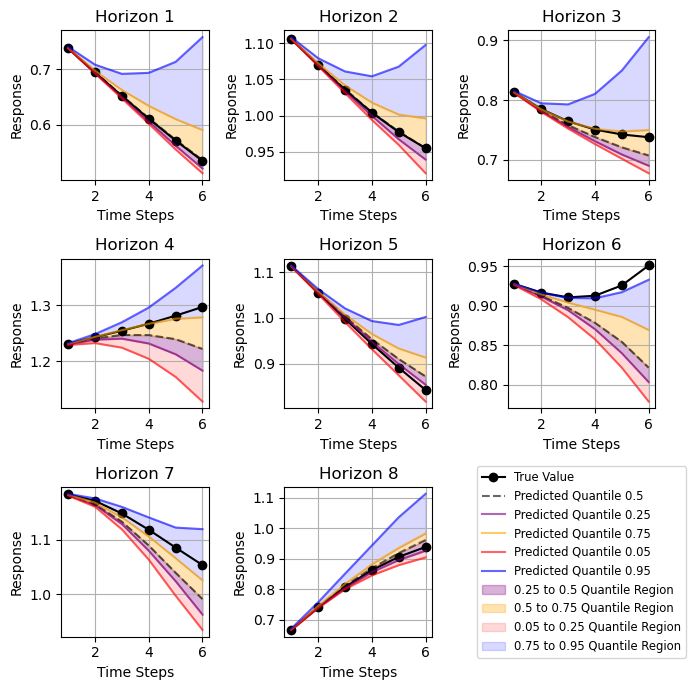

In [19]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

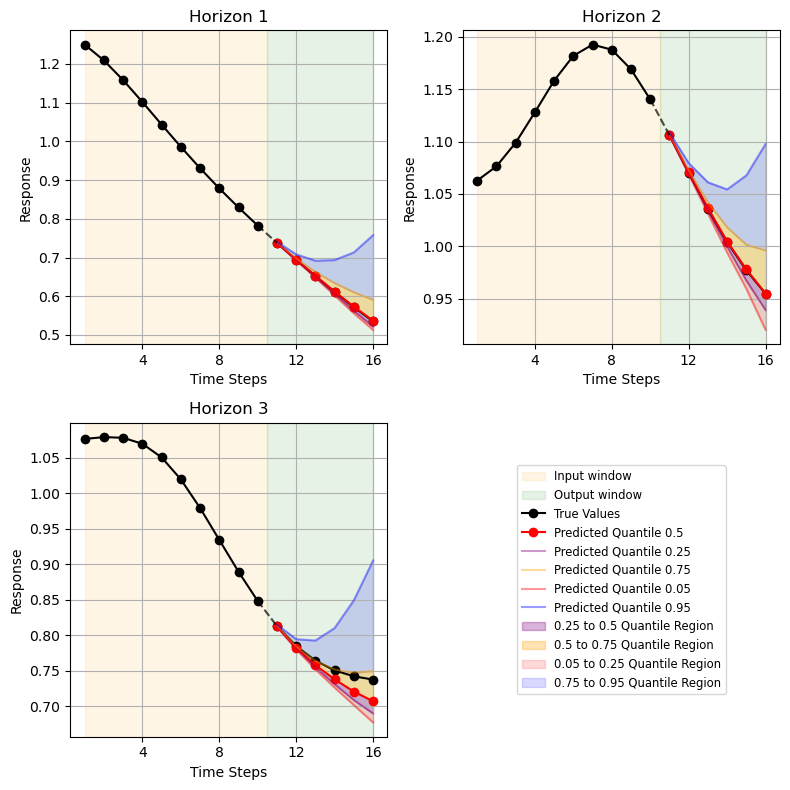

In [20]:
# Alternate display of results (include input)
X_test_inv = scaler.inverse_transform(X_test)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(3):
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='orange', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='green', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], actual_values[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.5])[i], marker='o', linestyle='-', color='red', label='Predicted Quantile 0.5')
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.4)
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], actual_values[i][0]], linestyle='--', color='black', alpha=0.7)

    # Highlight regions between quantiles
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[3])
# Add legend in the 9th subplot's space
axs[3] = fig.add_subplot(2, 2, 4)
axs[3].axis('off')  # Hide the axes for the legend subplot
axs[3].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [21]:
# 3. Lorenz (https://en.wikipedia.org/wiki/Lorenz_system)
def lorenz(xyz, *, s=10, r=28, b=2.667):
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# break it down to 3 univariate time series
x_dimension = xyzs[:, 0]
y_dimension = xyzs[:, 1]
z_dimension = xyzs[:, 2]

In [22]:
x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
y_dimension = y_dimension.flatten()
y_dimension = pd.Series(y_dimension, name='Value')
z_dimension = z_dimension.flatten()
z_dimension = pd.Series(z_dimension, name='Value')

x_dimension.index = range(len(x_dimension))
y_dimension.index = range(len(y_dimension))
z_dimension.index = range(len(z_dimension))

scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
y_reshaped = np.array(y_dimension).reshape(-1, 1)
z_reshaped = np.array(z_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()
y_scaled = scaler.fit_transform(y_reshaped).flatten()
z_scaled = scaler.fit_transform(z_reshaped).flatten()

In [23]:
## Usage: define our parameters
input_size = 12        # 12 steps input (showcase our model can handle different input/output sizes)
output_size = 8        # 8 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

x_rmse, x_mae, x_mape = [], [], []
y_rmse, y_mae, y_mape = [], [], []
z_rmse, z_mae, z_mape = [], [], []

metrics = ['rmse', 'mae', 'mape']
variables = ['x', 'y', 'z']
metric_dict = {f"{var}_{metric}_steps": [[] for _ in range(output_size)] for var in variables for metric in metrics}

In [24]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    x_mse = mean_squared_error(y_test, y_pred)
    x_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        x_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['x_rmse_steps'][step].append(np.sqrt(x_mse_step))

    # Inverse Transform
    x_predicted_values = scaler.inverse_transform(y_pred)
    x_actual_values = scaler.inverse_transform(y_test)

    x_mae.append(mean_absolute_error(x_actual_values, x_predicted_values))
    x_mape.append(mean_absolute_percentage_error(x_actual_values, x_predicted_values))

    actual_values_steps = list(zip(*x_actual_values))
    predicted_values_steps = list(zip(*x_predicted_values))

    for step in range(output_size):
        metric_dict['x_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['x_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    ####

    X_train, X_test, y_train, y_test = split_series(y_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_mse = mean_squared_error(y_test, y_pred)
    y_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        y_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['y_rmse_steps'][step].append(np.sqrt(y_mse_step))


    # Inverse Transform
    y_predicted_values = scaler.inverse_transform(y_pred)
    y_actual_values = scaler.inverse_transform(y_test)
    
    y_mae.append(mean_absolute_error(y_actual_values, y_predicted_values))
    y_mape.append(mean_absolute_percentage_error(y_actual_values, y_predicted_values))

    actual_values_steps = list(zip(*y_actual_values))
    predicted_values_steps = list(zip(*y_predicted_values))

    for step in range(output_size):
        metric_dict['y_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['y_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    ####

    X_train, X_test, y_train, y_test = split_series(z_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    z_mse = mean_squared_error(y_test, y_pred)
    z_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        z_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['z_rmse_steps'][step].append(np.sqrt(z_mse_step))

    # Inverse Transform
    z_predicted_values = scaler.inverse_transform(y_pred)
    z_actual_values = scaler.inverse_transform(y_test)
    
    z_mae.append(mean_absolute_error(z_actual_values, z_predicted_values))
    z_mape.append(mean_absolute_percentage_error(z_actual_values, z_predicted_values))

    actual_values_steps = list(zip(*z_actual_values))
    predicted_values_steps = list(zip(*z_predicted_values))

    for step in range(output_size):
        metric_dict['z_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['z_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    
    # print(f"Exp {i+1} on x test set: RMSE: {x_rmse[i]:.7f}, MAE: {x_mae[i]:.5f}, MAPE: {x_mape[i]:.7f}")
    seed += 1

print(f"Linear Regression x dimension: Avg RMSE: {np.mean(x_rmse):.6f} {pm} {np.std(x_rmse):.6f}, Avg MAE: {np.mean(x_mae):.4f} {pm} {np.std(x_mae):.4f}, Avg MAPE: {np.mean(x_mape)*100:.4f}% {pm} {np.std(x_mape)*100:.4f}%")
print(f"Linear Regression y dimension: Avg RMSE: {np.mean(y_rmse):.6f} {pm} {np.std(y_rmse):.6f}, Avg MAE: {np.mean(y_mae):.4f} {pm} {np.std(y_mae):.4f}, Avg MAPE: {np.mean(y_mape)*100:.4f}% {pm} {np.std(y_mape)*100:.4f}%")
print(f"Linear Regression z dimension: Avg RMSE: {np.mean(z_rmse):.6f} {pm} {np.std(z_rmse):.6f}, Avg MAE: {np.mean(z_mae):.4f} {pm} {np.std(z_mae):.4f}, Avg MAPE: {np.mean(z_mape)*100:.4f}% {pm} {np.std(z_mape)*100:.4f}%")

for step in range(output_size):
    print(f"At time step {step + 1}: ")
    print(f"     X Dimension - Avg RMSE: {np.mean(metric_dict['x_rmse_steps'][step]):.4f} {pm} {np.std(metric_dict['x_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['x_mae_steps'][step]):.4f} {pm} {np.std(metric_dict['x_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['x_mape_steps'][step])*100:.3f}% {pm} {np.std(metric_dict['x_mape_steps'][step])*100:.3f}%")
    print(f"     Y Dimension - Avg RMSE: {np.mean(metric_dict['y_rmse_steps'][step]):.4f} {pm} {np.std(metric_dict['y_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['y_mae_steps'][step]):.4f} {pm} {np.std(metric_dict['y_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['y_mape_steps'][step])*100:.3f}% {pm} {np.std(metric_dict['y_mape_steps'][step])*100:.3f}%")
    print(f"     Z Dimension - Avg RMSE: {np.mean(metric_dict['z_rmse_steps'][step]):.4f} {pm} {np.std(metric_dict['z_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['z_mae_steps'][step]):.4f} {pm} {np.std(metric_dict['z_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['z_mape_steps'][step])*100:.3f}% {pm} {np.std(metric_dict['z_mape_steps'][step])*100:.3f}%")

Linear Regression x dimension: Avg RMSE: 0.075505 ± 0.000000, Avg MAE: 0.0036 ± 0.0001, Avg MAPE: 0.0233% ± 0.0022%
Linear Regression y dimension: Avg RMSE: 0.075505 ± 0.000000, Avg MAE: 0.0138 ± 0.0004, Avg MAPE: 0.0876% ± 0.0073%
Linear Regression z dimension: Avg RMSE: 0.075505 ± 0.000000, Avg MAE: 0.0137 ± 0.0004, Avg MAPE: 0.0682% ± 0.0036%
At time step 1: 
     X Dimension - Avg RMSE: 0.0002 ± 0.0002, Avg MAE: 0.0000 ± 0.0000, Avg MAPE: 0.000% ± 0.000%
     Y Dimension - Avg RMSE: 0.0009 ± 0.0022, Avg MAE: 0.0000 ± 0.0000, Avg MAPE: 0.000% ± 0.000%
     Z Dimension - Avg RMSE: 0.0010 ± 0.0023, Avg MAE: 0.0000 ± 0.0000, Avg MAPE: 0.000% ± 0.000%
At time step 2: 
     X Dimension - Avg RMSE: 0.0001 ± 0.0002, Avg MAE: 0.0000 ± 0.0000, Avg MAPE: 0.000% ± 0.000%
     Y Dimension - Avg RMSE: 0.0004 ± 0.0007, Avg MAE: 0.0001 ± 0.0000, Avg MAPE: 0.000% ± 0.000%
     Z Dimension - Avg RMSE: 0.0004 ± 0.0004, Avg MAE: 0.0001 ± 0.0000, Avg MAPE: 0.000% ± 0.000%
At time step 3: 
     X Dimens

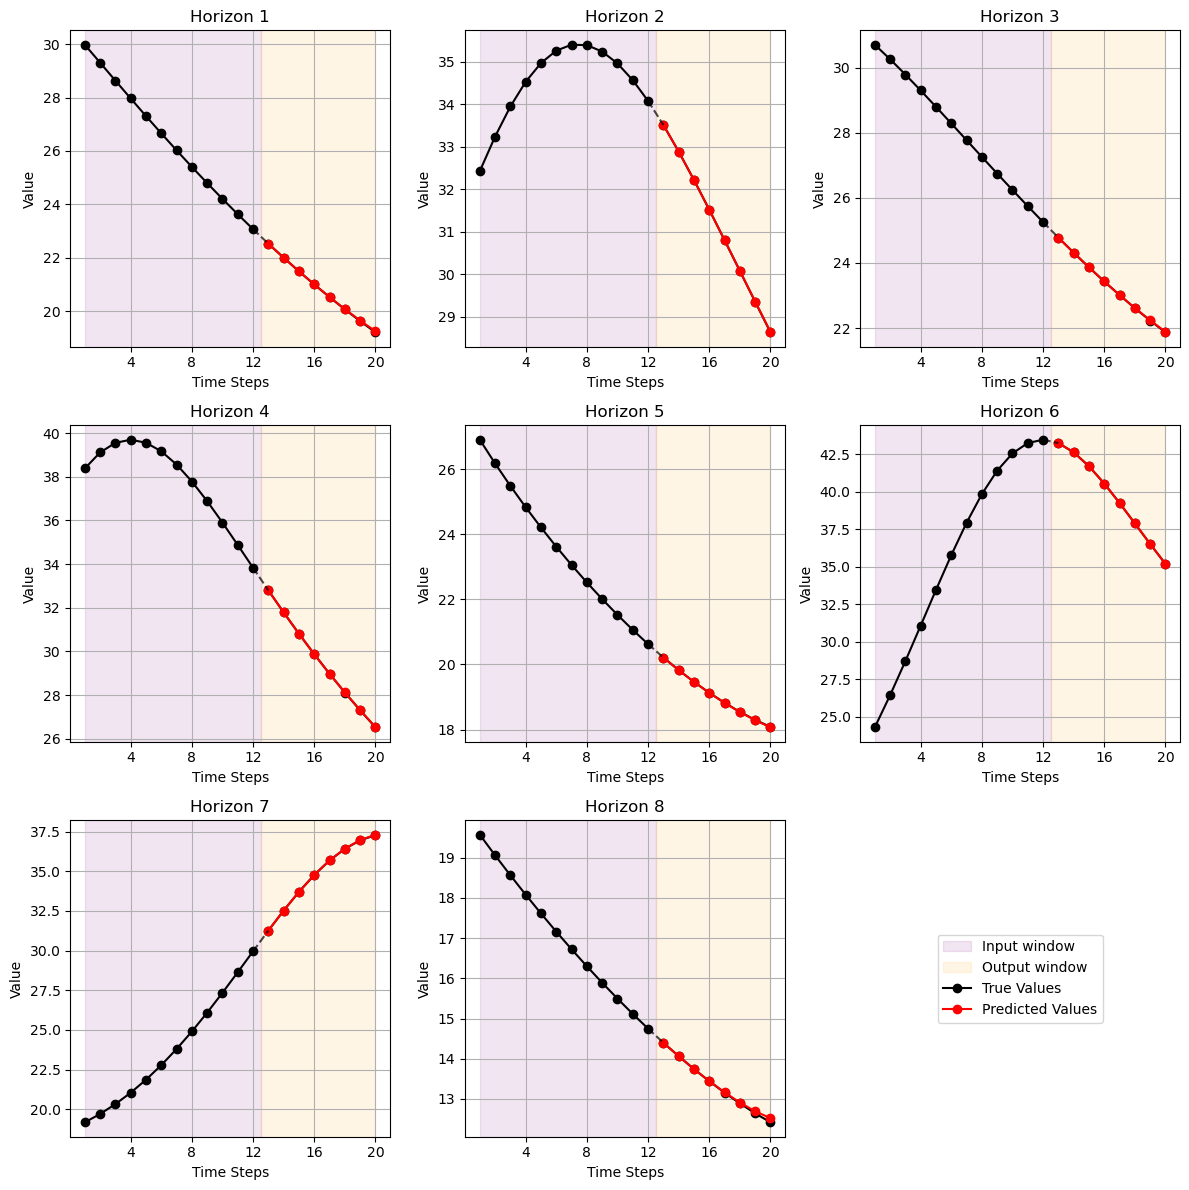

In [25]:
X_test_inv = scaler.inverse_transform(X_test)
# Time steps for the entire sequence (input + output)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for i in range(8):    
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='purple', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='orange', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], z_actual_values[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], z_predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Values')
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], z_actual_values[i][0]],
            linestyle='--', color='black', alpha=0.7)
    
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center') 


plt.tight_layout()
plt.show()

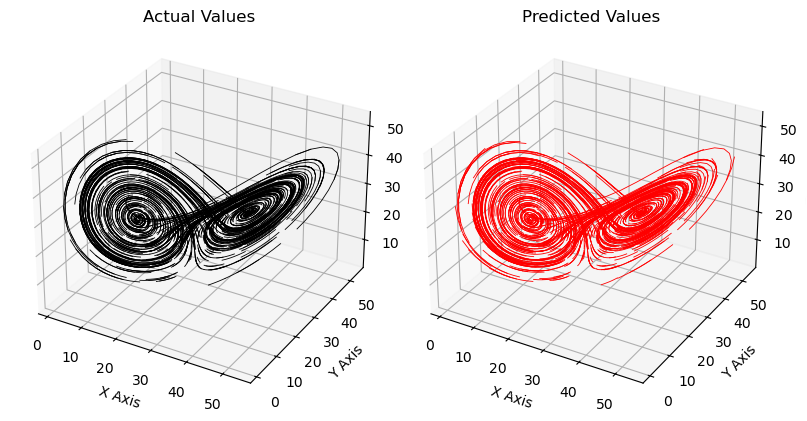

In [26]:
## Above are some example results for Z dimension - results are extremely accurate
# Going for a different approach to show result
# Figure 1: Actual Values
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(121, projection='3d')  # 121 means 1 row, 2 columns, plot 1

# Plot the data points
for i in range(len(x_actual_values)):
    ax1.plot(x_actual_values[i], y_actual_values[i], z_actual_values[i], linestyle='-', color='black', lw = 0.6)

# Set labels and title
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')
ax1.set_title('Actual Values')

# Figure 2: Predicted Values
ax2 = fig.add_subplot(122, projection='3d')  # 122 means 1 row, 2 columns, plot 2

# Plot the data points
for i in range(len(x_predicted_values)):
    ax2.plot(x_predicted_values[i], y_predicted_values[i], z_predicted_values[i], linestyle='-', color='red', lw = 0.6)

# Set labels and title
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Z Axis')
ax2.set_title('Predicted Values')

# Show both plots side by side
plt.tight_layout()
plt.show()

In [27]:
## Makes me want to do a huge time prediction
## Extreme Multi-Step Ahead Chaotic Time Series Prediction
# Input: 200
# Output: 100

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

x_dimension = xyzs[:, 0]

x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
x_dimension.index = range(len(x_dimension))

scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()

In [28]:
input_size = 200         
output_size = 100        
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

x_rmse, x_mae, x_mape = [], [], []
metrics = ['rmse', 'mae', 'mape']
variables = ['x']
metric_dict = {f"{var}_{metric}_steps": [[] for _ in range(output_size)] for var in variables for metric in metrics}

In [29]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    x_mse = mean_squared_error(y_test, y_pred)
    x_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        x_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['x_rmse_steps'][step].append(np.sqrt(x_mse_step))

    # Inverse Transform
    x_predicted_values = scaler.inverse_transform(y_pred)
    x_actual_values = scaler.inverse_transform(y_test)

    x_mae.append(mean_absolute_error(x_actual_values, x_predicted_values))
    x_mape.append(mean_absolute_percentage_error(x_actual_values, x_predicted_values))

    actual_values_steps = list(zip(*x_actual_values))
    predicted_values_steps = list(zip(*x_predicted_values))

    for step in range(output_size):
        metric_dict['x_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['x_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on x test set: RMSE: {x_rmse[i]:.7f}, MAE: {x_mae[i]:.5f}, MAPE: {x_mape[i]:.7f}")
    seed += 1

print(f"Lorenz System Linear Regression x dimension: ")
print(f"Across {output_size} predictive time steps, Avg RMSE: {np.mean(x_rmse):.4f} {pm} {np.std(x_rmse):.4f}, Avg MAE: {np.mean(x_mae):.2f} {pm} {np.std(x_mae):.2f}, Avg MAPE: {np.mean(x_mape)*100:.2f}% {pm} {np.std(x_mape)*100:.2f}%")

for step in range(output_size):
    if step == 0 or (step + 1) % 10 == 0:
        print(f"At time step {step + 1}, Avg RMSE: {np.mean(metric_dict['x_rmse_steps'][step]):.4f} {pm} {np.std(metric_dict['x_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['x_mae_steps'][step]):.4f} {pm} {np.std(metric_dict['x_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['x_mape_steps'][step])*100:.3f}% {pm} {np.std(metric_dict['x_mape_steps'][step])*100:.3f}%")


Lorenz System Linear Regression x dimension: 
Across 100 predictive time steps, Avg RMSE: 0.0755 ± 0.0000, Avg MAE: 4.76 ± 0.19, Avg MAPE: 147.84% ± 7.60%
At time step 1, Avg RMSE: 0.1311 ± 0.0479, Avg MAE: 0.0000 ± 0.0000, Avg MAPE: 0.000% ± 0.000%
At time step 10, Avg RMSE: 0.1568 ± 0.0614, Avg MAE: 0.0215 ± 0.0098, Avg MAPE: 0.650% ± 0.256%
At time step 20, Avg RMSE: 0.1330 ± 0.0376, Avg MAE: 0.9810 ± 0.2937, Avg MAPE: 31.569% ± 9.878%
At time step 30, Avg RMSE: 0.1552 ± 0.0766, Avg MAE: 3.5431 ± 0.6678, Avg MAPE: 110.006% ± 31.332%
At time step 40, Avg RMSE: 0.1399 ± 0.0491, Avg MAE: 5.5078 ± 0.5516, Avg MAPE: 304.916% ± 124.478%
At time step 50, Avg RMSE: 0.1451 ± 0.0524, Avg MAE: 6.3750 ± 0.2751, Avg MAPE: 255.945% ± 76.410%
At time step 60, Avg RMSE: 0.1646 ± 0.0614, Avg MAE: 6.7086 ± 0.1869, Avg MAPE: 201.976% ± 63.358%
At time step 70, Avg RMSE: 0.1538 ± 0.0601, Avg MAE: 6.8197 ± 0.1448, Avg MAPE: 156.521% ± 26.487%
At time step 80, Avg RMSE: 0.1481 ± 0.0501, Avg MAE: 6.8930 ±

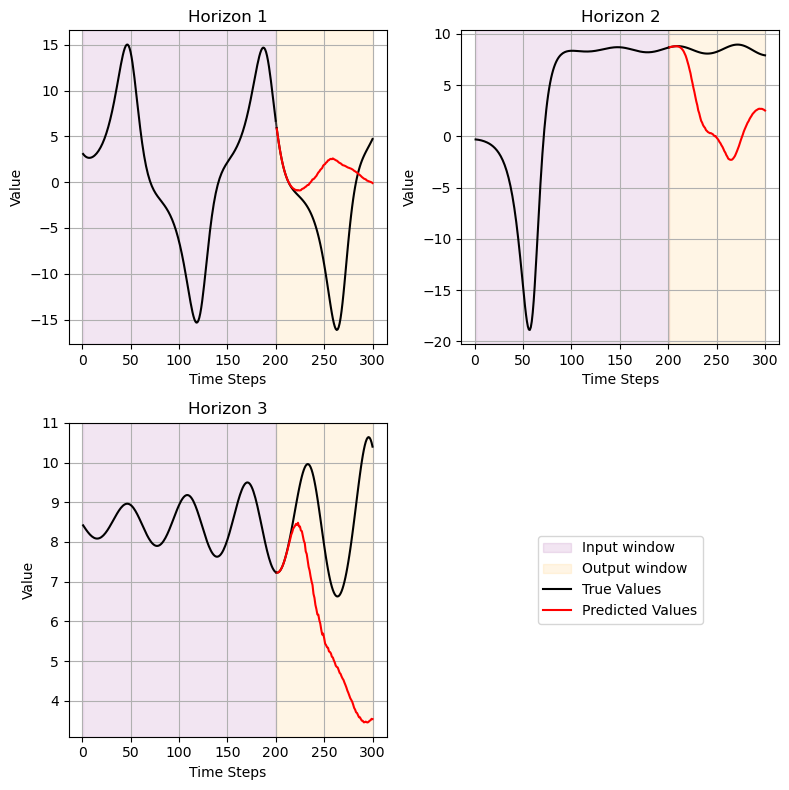

In [30]:
X_test_inv = scaler.inverse_transform(X_test)
# Time steps for the entire sequence (input + output)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(3):    
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='purple', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='orange', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], x_actual_values[i], linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], x_predicted_values[i], linestyle='-', color='red', label='Predicted Values')
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], x_actual_values[i][0]],
            linestyle='--', color='black', alpha=0.7)
    
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[3])
# Add legend in the 9th subplot's space
axs[3] = fig.add_subplot(2, 2, 4)
axs[3].axis('off')  # Hide the axes for the legend subplot
axs[3].legend(handles=handles, labels=labels, loc='center') 

plt.tight_layout()
plt.show()

In [31]:
# to be honest, it's not too bad considering we are predicting 100 values into the future
# but of course, the code did not capture the whole shape so there is always room to improve

In [32]:
## Quantile Version
dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# break it down to 3 univariate time series
x_dimension = xyzs[:, 0]
y_dimension = xyzs[:, 1]
z_dimension = xyzs[:, 2]

x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
y_dimension = y_dimension.flatten()
y_dimension = pd.Series(y_dimension, name='Value')
z_dimension = z_dimension.flatten()
z_dimension = pd.Series(z_dimension, name='Value')

x_dimension.index = range(len(x_dimension))
y_dimension.index = range(len(y_dimension))
z_dimension.index = range(len(z_dimension))

scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
y_reshaped = np.array(y_dimension).reshape(-1, 1)
z_reshaped = np.array(z_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()
y_scaled = scaler.fit_transform(y_reshaped).flatten()
z_scaled = scaler.fit_transform(z_reshaped).flatten()

In [33]:
# Usage
input_size = 12        # 12 steps input
output_size = 8        # 8 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # change to lower value for less intensive runs

rmse, mae, mape = [], [], []
quantile_rmse = {q: [] for q in quantiles}
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [34]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    print(f"Experiment {i+1}/{num_experiments} done")
    seed += 1

print(f"Lorenz X-Dimension Quantile Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f} {pm} {np.std(quantile_rmse[q]):.4f}")

Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done
Experiment 23/30 done
Experiment 24/30 done
Experiment 25/30 done
Experiment 26/30 done
Experiment 27/30 done
Experiment 28/30 done
Experiment 29/30 done
Experiment 30/30 done
Lorenz X-Dimension Quantile Linear Regression: After 30 experimental runs, here are the results:
Across 8 predictive time steps, Avg RMSE: 0.0027 ± 0.0003, Avg MAE: 0.04 ± 0.00, Avg MAPE: 0.299% ± 0.049%
At time step 1, Avg RMSE: 0.0023 ± 0.0061, Avg MAE: 0.01 ± 0.01, Avg MAPE: 0.063% ± 0.045%
At time step 2, Avg RMSE: 0.0011 ± 0.0020, Avg MAE: 0.

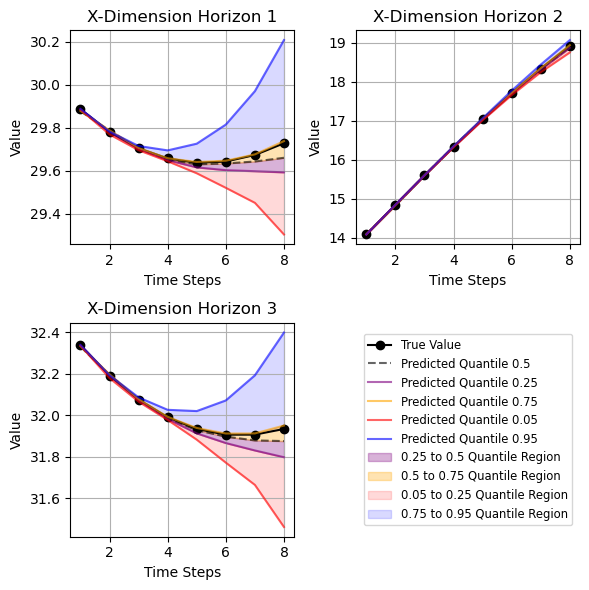

In [35]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i in range(3):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'X-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

fig.delaxes(axs[3])
# Add legend in the 9th subplot's space
axs[3] = fig.add_subplot(2, 2, 4)
axs[3].axis('off')  # Hide the axes for the legend subplot
axs[3].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [36]:
input_size = 12        # 12 steps input
output_size = 8        # 8 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # change to lower value for less intensive runs

rmse, mae, mape = [], [], []
quantile_rmse = {q: [] for q in quantiles}
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [37]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(y_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    print(f"Experiment {i+1}/{num_experiments} done")
    seed += 1

print(f"Lorenz Y-Dimension Quantile Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f} {pm} {np.std(quantile_rmse[q]):.4f}")

Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done
Experiment 23/30 done
Experiment 24/30 done
Experiment 25/30 done
Experiment 26/30 done
Experiment 27/30 done
Experiment 28/30 done
Experiment 29/30 done
Experiment 30/30 done
Lorenz Y-Dimension Quantile Linear Regression: After 30 experimental runs, here are the results:
Across 8 predictive time steps, Avg RMSE: 0.0060 ± 0.0010, Avg MAE: 0.08 ± 0.01, Avg MAPE: 0.477% ± 0.055%
At time step 1, Avg RMSE: 0.0049 ± 0.0152, Avg MAE: 0.01 ± 0.01, Avg MAPE: 0.043% ± 0.045%
At time step 2, Avg RMSE: 0.0020 ± 0.0028, Avg MAE: 0.

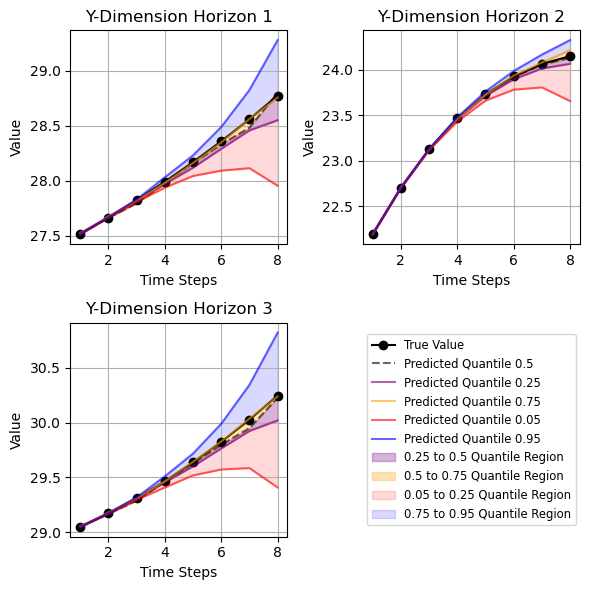

In [38]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i in range(3):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Y-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

fig.delaxes(axs[3])
# Add legend in the 9th subplot's space
axs[3] = fig.add_subplot(2, 2, 4)
axs[3].axis('off')  # Hide the axes for the legend subplot
axs[3].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [39]:
input_size = 12        # 12 steps input
output_size = 8        # 8 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # change to lower value for less intensive runs

rmse, mae, mape = [], [], []
quantile_rmse = {q: [] for q in quantiles}
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [40]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(z_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    print(f"Experiment {i+1}/{num_experiments} done")
    seed += 1

print(f"Lorenz Z-Dimension Quantile Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f} {pm} {np.std(quantile_rmse[q]):.4f}")

Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done
Experiment 23/30 done
Experiment 24/30 done
Experiment 25/30 done
Experiment 26/30 done
Experiment 27/30 done
Experiment 28/30 done
Experiment 29/30 done
Experiment 30/30 done
Lorenz Z-Dimension Quantile Linear Regression: After 30 experimental runs, here are the results:
Across 8 predictive time steps, Avg RMSE: 0.0065 ± 0.0009, Avg MAE: 0.08 ± 0.01, Avg MAPE: 0.314% ± 0.016%
At time step 1, Avg RMSE: 0.0054 ± 0.0155, Avg MAE: 0.01 ± 0.01, Avg MAPE: 0.051% ± 0.037%
At time step 2, Avg RMSE: 0.0031 ± 0.0084, Avg MAE: 0.

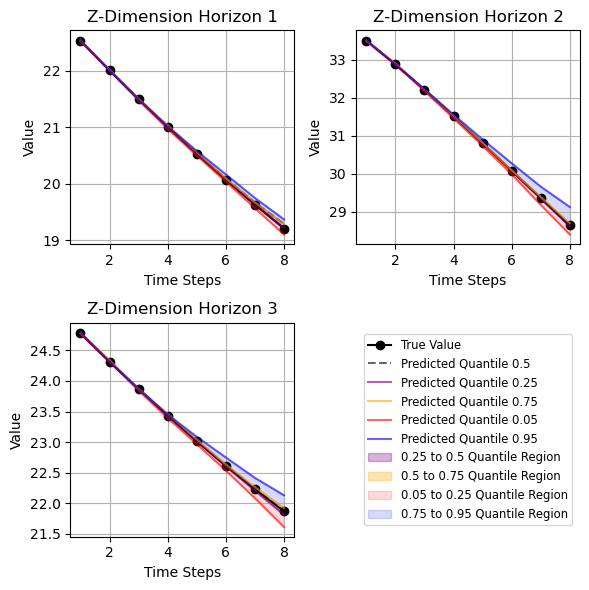

In [41]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i in range(3):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Z-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

fig.delaxes(axs[3])
# Add legend in the 9th subplot's space
axs[3] = fig.add_subplot(2, 2, 4)
axs[3].axis('off')  # Hide the axes for the legend subplot
axs[3].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()